In [33]:
import torch
import dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [34]:
model_path = '/opt/ml/upstage_OCR/code/saved/unet_focal_g_00_78_t1/model.pt'
state_dict_path = '/opt/ml/upstage_OCR/code/saved/unet_focal_g_00_78_t1/250.pt'

model = torch.load(model_path)
model.load_state_dict(torch.load(state_dict_path))

ann_path = '/opt/ml/upstage_OCR/Data set/annotations/general_148_180.json'
ocr_url = "http://118.222.179.32:30000/ocr/"
image_root = '/opt/ml/upstage_OCR/Data set/real data/general'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
transform = A.Compose([
    A.Resize(512,512),
    ToTensorV2()
])

test_dataset = dataset.WifiDataset_segmentation(ann_path,ocr_url,image_root,transform=transform,preload=False)

loading annotations into memory...
Done (t=0.00s)


In [35]:
# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=4,
                                           shuffle=True,
                                           collate_fn=collate_fn)

iter_ = iter(test_dataloader)

In [36]:
x,y,meta = next(iter_)
model.eval()
images = model(torch.stack(x).to(device))

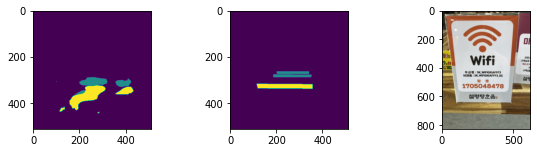

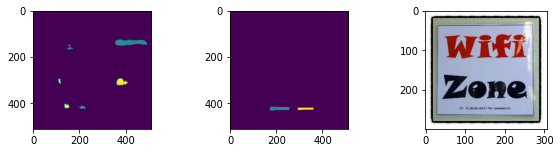

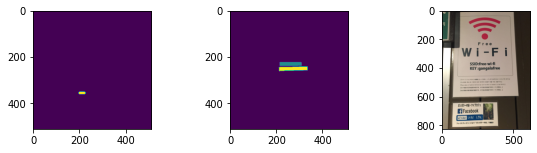

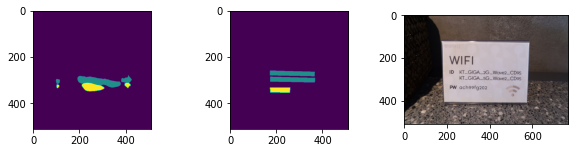

In [37]:
import matplotlib.pyplot as plt
import torchvision
import os
from PIL import Image
import numpy as np

for idx in range(4):
    image = images[idx]
    out = torch.argmax(image,dim=0)
    image_meta = meta[idx][0]

    raw_image = Image.open(os.path.join(image_root,image_meta['file_name']))
    t = A.Compose([
        A.Resize(image_meta['height'],image_meta['width']),
        ToTensorV2()
    ])
    t2 = torchvision.transforms.ToPILImage()

    plt.figure(figsize=(10,10))

    plt.subplot(4,3,idx*3+1)
    plt.imshow(t2(out*0.3))

    plt.subplot(4,3,idx*3+2)
    plt.imshow(t2(y[idx]*0.3))

    plt.subplot(4,3,idx*3+3)
    plt.imshow(raw_image)

plt.show()